# Part 1: Natural Language Processing

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter

# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# For dataset loading
from sklearn.datasets import fetch_20newsgroups

# For modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Load a subset of the 20 Newsgroups dataset
categories = ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, random_state=42)

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
   'text': newsgroups.data,
   'category': [newsgroups.target_names[target] for target in newsgroups.target]
})

# Preview the data
print(f"Dataset shape: {df.shape}")
print("\nCategory distribution:")
print(df['category'].value_counts())
print("\nSample document:")
print(df['text'][10][:500])  # Print first 500 characters of a sample document

Dataset shape: (2236, 2)

Category distribution:
rec.autos             594
sci.space             593
comp.graphics         584
talk.politics.misc    465
Name: category, dtype: int64

Sample document:
From: bob1@cos.com (Bob Blackshaw)
Subject: Re: Dumbest Driver Action
Organization: Corporation for Open Systems
Distribution: usa 
Lines: 41

In <C5Dq2n.5uB@news.cso.uiuc.edu> mwbg9715@uxa.cso.uiuc.edu (Mark Wayne Blunier) writes:

>jimf@centerline.com (Jim Frost) writes:

>>I wish I had the figures with me to back me up, but I recall
>>statistics showing that women tended to have more accidents than men
>>but the damage was generally quite minor.  Men had fewer but far more
>>expensive acciden


[nltk_data] Downloading package punkt to /home/asdfg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/asdfg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/asdfg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/asdfg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /home/asdfg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/asdfg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
df.head()

,text,category
0,From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...,comp.graphics
1,From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...,talk.politics.misc
2,From: rick@trystro.uucp (Richard Nickle)\nSubj...,sci.space
3,From: marshatt@feserve.cc.purdue.edu (Zauberer...,rec.autos
4,From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...,talk.politics.misc


In [37]:
# Preprocess text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Helper function for lemmatization with POS tagging
def get_wordnet_pos(treebank_tag):
    """
    Convert NLTK POS tags to WordNet POS tags
    """
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN

def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    # Remove special characters/numbers
    # Removing punctuation will make email addresses hard to identify, but their frequency should be low so they won't have a large impact on analysis
    html_clean = re.compile('<.*?>')
    text = re.sub(html_clean, '', text)                 # Remove html tags
    text = " ".join([w for w in text.split(' ') if len(w) >= 2])   # Keep only words 2+ characters long
    text = re.sub(r'[^\w\s]', '', text)                 # Remove punctuation
        
    # Tokenize
    tokens = word_tokenize(text)

    # Convert to lowercase and remove stop words
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]

    # Lemmatize or stem tokens
    tagged_tokens = nltk.pos_tag(tokens)
    pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tagged_tokens]
    lem_tokens = [lemmatizer.lemmatize(word[0], word[1]) for word in pos_tokens]
    
    # Return the cleaned token list
    return ' '.join(lem_tokens)

In [ ]:
df['processed_tokens'] = df['text'].apply(preprocess_text)
df['processed_tokens'] = df['processed_tokens'].apply(lambda x: x.split(' '))

In [41]:
df.head()

,text,category,processed_tokens
0,From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...,comp.graphics,"[nfotisntuagr, nick, c, fotis, subject, radios..."
1,From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...,talk.politics.misc,"[cdmpmafireinelgov, dale, cook, subject, good,..."
2,From: rick@trystro.uucp (Richard Nickle)\nSubj...,sci.space,"[ricktrystrouucp, richard, nickle, subject, re..."
3,From: marshatt@feserve.cc.purdue.edu (Zauberer...,rec.autos,"[marshattfeserveccpurdueedu, zauberer, subject..."
4,From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...,talk.politics.misc,"[clintonhqcampaign92org, clintongore, 92, subj..."


In [42]:
# Single words
counter = Counter([token for doc in df['processed_tokens'] for token in doc])
print(counter.most_common(20))

# Bigrams
from nltk.util import ngrams
bigram_counts = Counter(ngrams(df['processed_tokens'].sum(), 2))
print(bigram_counts.most_common(20))

[('line', 2591), ('subject', 2389), ('organization', 2307), ('would', 1967), ('write', 1853), ('get', 1702), ('article', 1664), ('one', 1562), ('use', 1530), ('go', 1350), ('dont', 1282), ('space', 1281), ('think', 1265), ('make', 1263), ('car', 1262), ('say', 1249), ('know', 1224), ('like', 1221), ('university', 1139), ('people', 1119)]
[(('organization', 'university'), 374), (('mr', 'stephanopoulos'), 341), (('write', 'article'), 313), (('dont', 'know'), 210), (('distribution', 'world'), 207), (('usa', 'line'), 186), (('distribution', 'usa'), 146), (('dont', 'think'), 131), (('would', 'like'), 122), (('university', 'line'), 119), (('world', 'nntppostinghost'), 118), (('anyone', 'know'), 113), (('writes', 'article'), 112), (('state', 'university'), 110), (('im', 'sure'), 108), (('new', 'york'), 106), (('space', 'station'), 102), (('health', 'care'), 99), (('united', 'state'), 98), (('henry', 'spencer'), 96)]


In [43]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['category'],
    test_size=0.2,
    random_state=42,
    stratify=df['category']
)

# Create and fit a Bag of Words vectorizer (preprocessor=preprocess_text, max_features=50)
count_vectorizer = CountVectorizer(
    preprocessor=preprocess_text,
    max_features=50
)
X_train_counts = count_vectorizer.fit_transform(X_train)

# Create and fit a TF-IDF vectorizer (preprocessor=preprocess_text, max_features=50)
tfidf_vectorizer = TfidfVectorizer(
    preprocessor=preprocess_text,
    max_features=50
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [ ]:
# Run this cell without changes
# Confirm the split
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"\nClass distribution in training set:\n{y_train.value_counts()}")
print(f"\nClass distribution in testing set:\n{y_test.value_counts()}")

# Examine the vocabulary size for each vectorizer
count_vocab_size = len(count_vectorizer.get_feature_names_out())
tfidf_vocab_size = len(tfidf_vectorizer.get_feature_names_out())

print(f"Bag of Words vocabulary size: {count_vocab_size}")
print(f"TF-IDF vocabulary size: {tfidf_vocab_size}")

# Examine the feature matrices
print(f"\nBag of Words feature matrix shape: {X_train_counts.shape}")
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Show the first few feature names
print(f"\nSample of feature names: {count_vectorizer.get_feature_names_out()[:10]}")

Training set size: 1788
Testing set size: 448

Class distribution in training set:
rec.autos             475
sci.space             474
comp.graphics         467
talk.politics.misc    372
Name: category, dtype: int64

Class distribution in testing set:
sci.space             119
rec.autos             119
comp.graphics         117
talk.politics.misc     93
Name: category, dtype: int64
Bag of Words vocabulary size: 50
TF-IDF vocabulary size: 50

Bag of Words feature matrix shape: (1788, 50)
TF-IDF feature matrix shape: (1788, 50)

Sample of feature names: ['also' 'article' 'car' 'could' 'dont' 'even' 'file' 'find' 'first' 'get']


In [ ]:
# Create and train a Multinomial Naive Bayes model with Bag of Words features
nb_bow = MultinomialNB(alpha=1.0)
nb_bow.fit(X_train_counts, y_train)

# Create and train a Multinomial Naive Bayes model with TF-IDF features
nb_tfidf = MultinomialNB(alpha=1.0)
nb_tfidf.fit(X_train_tfidf, y_train)

In [48]:
# Transform the test data with both vectorizers
X_test_counts = count_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Predict on the test data with both models
y_pred_bow = nb_bow.predict(X_test_counts)
y_pred_tfidf = nb_tfidf.predict(X_test_counts)

# Function to evaluate a model and display results
def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate a model and display its performance metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True class labels
    y_pred : array-like
        Predicted class labels
    model_name : str
        Name of the model being evaluated
        
    Returns:
    --------
    float
        Accuracy score
    """
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Print evaluation results
    print(f"Evaluation for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Generate and print classification report
    report = classification_report(y_true, y_pred)
    print(f"\nClassification Report:\n{report}")
    
    # Return the accuracy
    return accuracy

Evaluation for Bag of Words + Naive Bayes:
Accuracy: 0.6987

Classification Report:
                    precision    recall  f1-score   support

     comp.graphics       0.68      0.72      0.70       117
         rec.autos       0.63      0.86      0.73       119
         sci.space       0.81      0.62      0.70       119
talk.politics.misc       0.74      0.57      0.64        93

          accuracy                           0.70       448
         macro avg       0.72      0.69      0.69       448
      weighted avg       0.71      0.70      0.70       448

Evaluation for TF-IDF + Naive Bayes:
Accuracy: 0.7545

Classification Report:
                    precision    recall  f1-score   support

     comp.graphics       0.69      0.84      0.75       117
         rec.autos       0.84      0.83      0.84       119
         sci.space       0.81      0.64      0.71       119
talk.politics.misc       0.70      0.70      0.70        93

          accuracy                           0.75    

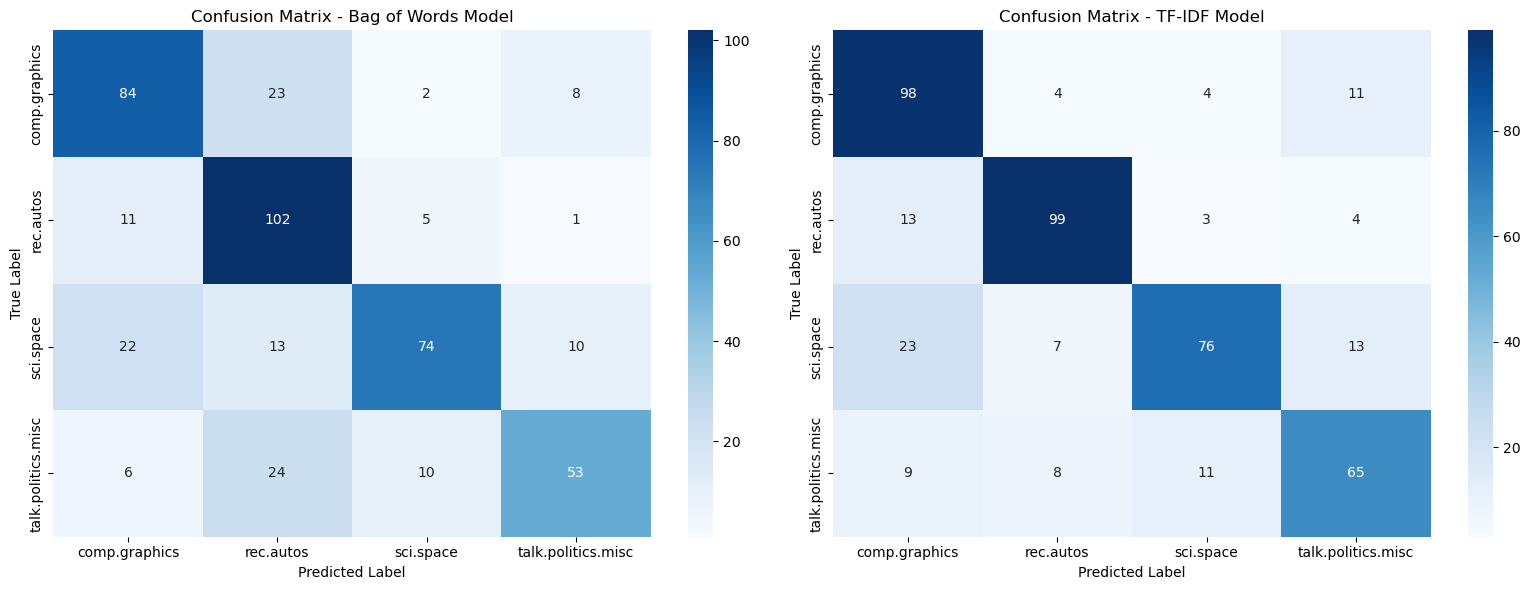

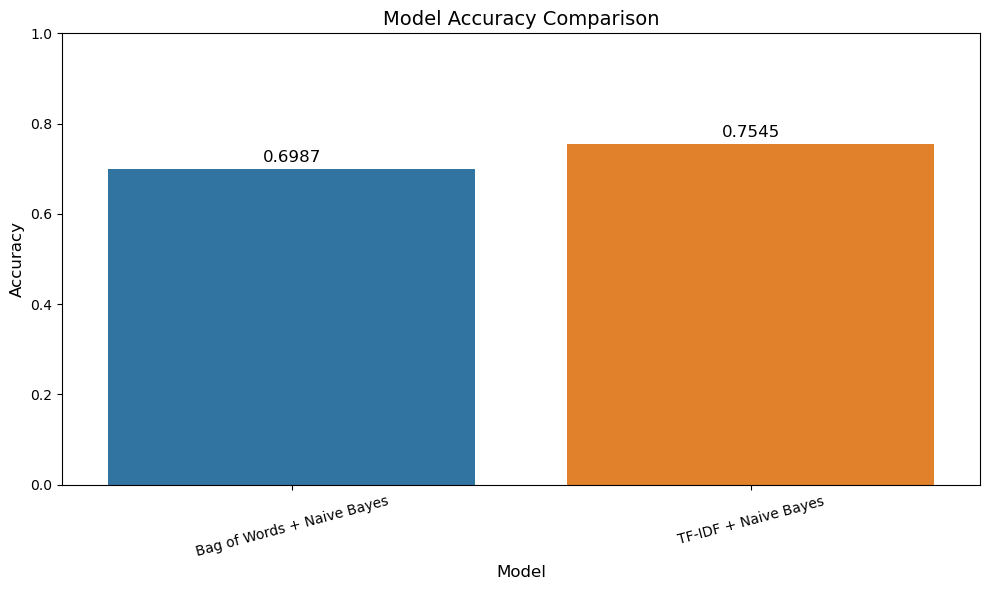

In [49]:
# Evaluate both models
bow_accuracy = evaluate_model(y_test, y_pred_bow, "Bag of Words + Naive Bayes")
tfidf_accuracy = evaluate_model(y_test, y_pred_tfidf, "TF-IDF + Naive Bayes")

# Create confusion matrices for both models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix for Bag of Words model
cm_bow = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', xticklabels=nb_bow.classes_, 
            yticklabels=nb_bow.classes_, ax=axes[0])
axes[0].set_title('Confusion Matrix - Bag of Words Model', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=10)
axes[0].set_ylabel('True Label', fontsize=10)

# Confusion matrix for TF-IDF model
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=nb_tfidf.classes_, 
            yticklabels=nb_tfidf.classes_, ax=axes[1])
axes[1].set_title('Confusion Matrix - TF-IDF Model', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=10)
axes[1].set_ylabel('True Label', fontsize=10)

plt.tight_layout()
plt.show()

# Compare model accuracies
models = ['Bag of Words + Naive Bayes', 'TF-IDF + Naive Bayes']
accuracies = [bow_accuracy, tfidf_accuracy]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=15)

# Add accuracy labels to the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# TF-IDF produces the more accurate model
text_clf = Pipeline([
    ('vectorizer', TfidfVectorizer(preprocessor=preprocess_text, lowercase=False)),
    ('classifier', MultinomialNB())
])

# Perform grid search to find best parameters
param_grid = {
    # Vectorizer type and parameters
    'vectorizer': [count_vectorizer, tfidf_vectorizer],
    
    # Parameters for CountVectorizer and TfidfVectorizer
    'vectorizer__max_features': [50, 75],
    'vectorizer__min_df': [1, 2, 3],
    'vectorizer__max_df': [0.85, 0.9, 0.95],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    
    # Classifier parameters
    'classifier__alpha': [0.5, 1.0]
}

# Create a grid search object
grid_search = GridSearchCV(
    text_clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Use the best estimator to make predictions on the test set
best_model = grid_search.best_estimator_
y_pred_grid = best_model.predict(X_test)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [1]:
print("Best Parameters:")
print(grid_search.best_params_)
print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f}")

Best Parameters:


NameError: name 'grid_search' is not defined

In [ ]:
# Evaluate improved model
improved_tfidf_accuracy = evaluate_model(y_test, y_pred_grid, "Improved TF-IDF + Naive Bayes")

## Reflection

This process may benefit from further refinement in what words to filter out. 'Subject' obviously shows up at least once per message, but it may be a semantically relevant word as well in the messages we receive.